In [51]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

In [217]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import os
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [2]:
from google.colab import files
uploaded = files.upload()

Saving pricedeathcor.csv to pricedeathcor.csv


#Preprocessing

In [211]:
def add_artist_event(df, name_list):
  data_proc_prev = df.copy()
  colList = ["log_nom_price","Christie's New York","Christie's London","Sotheby's New York","Sotheby's London"]
  prev_colList = []
  for col in colList:
    prev_string = "".join(("PA_",col))
    data_proc_prev[prev_string] = 0
  for name in name_list:
    for col in colList:
      prev_string = "".join(("PA_",col))
      data_proc_prev.loc[data_proc_prev[name]==1,prev_string] = data_proc.loc[data_proc[name]==1,col].shift(1)
  #adds a column to indicate if there are NA values
  data_proc_prev["no_prev_sale_artist"] = 0
  data_proc_prev["no_prev_sale_artist"] = data_proc_prev['PA_log_nom_price'].isna().apply(lambda x: 1 if x==True else 0)
  data_proc_prev = data_proc_prev.fillna(0)
  return data_proc_prev

def add_painting_event(df,paintingCode_list):
  data_proc_prev = df.copy()
  colList = ["log_nom_price","Christie's New York","Christie's London","Sotheby's New York","Sotheby's London"]
  prev_colList = []
  for col in colList:
    prev_string = "".join(("PP_",col))
    prev_colList += [prev_string]
    data_proc_prev[prev_string] = 0
  for code in tqdm(paintingCode_list):
    for col in colList:
      prev_string = "".join(("PP_",col))
      data_proc_prev.loc[data_proc_prev.painting_code == code,prev_string] = data_proc_prev.loc[data_proc_prev.painting_code == code,col].shift(1)   
  #adds a column to indicate if there are NA values
  data_proc_prev["no_prev_sale_painting"] = 0
  data_proc_prev["no_prev_sale_painting"] = data_proc_prev['PP_log_nom_price'].apply(lambda x: 1 if x>0 else 0)
  data_proc_prev = data_proc_prev.fillna(0)
  return data_proc_prev

In [256]:
#universal sentence encoder helper functions

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [295]:
data = pd.read_csv("pricedeathcor.csv",encoding= 'unicode_escape')
artists = data.artist.unique()
mergelist = np.empty([len(artists),3],dtype=object)
for i,artist in enumerate(artists):
  name, info = artist.split(" (") #splits of name from year data
  _,death = info.split("d. ") # splits off death data from birth
  death = death[:-1] #removes trailing parenthesis
  mergelist[i] = [artist, name, death]
mergelist = pd.DataFrame(mergelist,columns=["artist","name","death"])
data = data.merge(mergelist)
data.death = pd.to_numeric(data.death)

#drops data from artists with less than a certain number of rows
e = data.groupby('name').aggregate({'nomprice':['count']})
f = np.asarray(e.nomprice)
e = e.nomprice[e.nomprice > 0]
prolific_names = e.dropna().index
data = data[data.name.isin(prolific_names)]

#drops data except for price estimates
top_houses = ["Christie's New York","Christie's London","Sotheby's New York","Sotheby's London"]
data = data[data.house.isin(top_houses)]
data = data.drop(["auction_name_lot","hammer","pdate","date","lot_no","curr","saleyear","omeana","larea","saleprice","cpi","american"],1)
medianPrice = np.asarray((data.low_est.values + data.high_est.values)/2)
salePrice = np.asarray(data.nomprice.values)
data = data.drop(["low_est","high_est"],axis=1)

#combines name and title strings to create unique painting code
data["painting_code"] = data.name + data.title.str[:3]
painting_codes = data[data.painting_code.duplicated()==True].painting_code.unique()

#dropping rows without sale price data
data = data[data.nomprice.isna()==False]
#dropping rows without titles for painting (this is only 4 rows so not impactful)
data = data[data.title.isna()==False]
#replacing NaN's from death columns to 0's for boolean encoding
data = data.fillna(0) #not specifying which columns since only cols remaining without Nan's are the death cols

#ADDED COLUMNS
#adds log nom price column
data["log_nom_price"] = np.log(data.nomprice)

#changes saledate string into pandas datetime and extracts the month and day
data["datestring"] = pd.to_datetime(data.datestring)
data["sale_year"] = pd.DatetimeIndex(data['datestring']).year
data["sale_month"] = pd.DatetimeIndex(data['datestring']).month
#data["sale_day"] = pd.DatetimeIndex(data['datestring']).day
#i commend out weekday, even though it does add a lot of info to model
#since the seller wouldnt know this ahead of time
#data["weekday"] = pd.DatetimeIndex(data['datestring']).dayofweek

#creates onehot vectors
name_onehot = pd.get_dummies(data.name)
house_onehot = pd.get_dummies(data.house)
data_proc = data.copy()

#joins onehot vectors
data_proc = data_proc.join(name_onehot)
data_proc = data_proc.join(house_onehot)

data_proc = data_proc.sort_values("sale_year").reset_index(drop=True)
#adds previous transaction data to each row
data_proc = add_artist_event(data_proc,prolific_names)
data_proc = add_painting_event(data_proc,painting_codes)
#data_proc = add_painting_event(data_proc,painting_codes)

#drops string data from df
data_proc = data_proc.drop("painting_code",axis = 1)
data_proc = data_proc.drop(["artist"],axis = 1)
data_proc = data_proc.drop("house",axis = 1)
data_proc = data_proc.drop("title",axis = 1)
data_proc = data_proc.drop("name",axis = 1)
data_proc = data_proc.drop("datestring",axis = 1)
#drops y data from input
data_proc = data_proc.drop("nomprice",axis = 1)

#adds title vectorizations
titlevect = embed(data.title)
df_title = pd.DataFrame(np.asarray(titlevect))
data_proc_titleVect = data_proc.merge(df_title,left_index=True,right_index=True)

#whether you use the title vectorization dataframe or not is up to you
trainSplit = int(.6*len(data_proc))
validSplit = int(.8*len(data_proc))

trainX = np.asarray(data_proc.iloc[:trainSplit].drop("log_nom_price",axis=1).values)
validX = np.asarray(data_proc.iloc[trainSplit:validSplit].drop("log_nom_price",axis=1).values)
testX = np.asarray(data_proc.iloc[validSplit:].drop("log_nom_price",axis=1).values)

trainy = np.asarray(data_proc.iloc[:trainSplit]["log_nom_price"].values)
validy = np.asarray(data_proc.iloc[trainSplit:validSplit]["log_nom_price"].values)
testy = np.asarray(data_proc.iloc[validSplit:]["log_nom_price"].values)

100%|██████████| 1272/1272 [00:18<00:00, 68.44it/s]


90it [00:01, 64.29it/s]


0.3947972688212844 1.6768095938006515


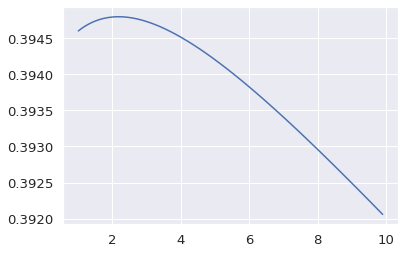

In [303]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,SGDRegressor,LogisticRegression,QuantileRegressor,HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

X = validX
y = validy

poly = PolynomialFeatures(2)

alphalist = np.arange(1,10,.1)
r2list = np.zeros(len(alphalist))

for i, a in tqdm(enumerate(alphalist)):
  reg = Ridge(alpha=a).fit(trainX, trainy)
  y_pred = reg.predict(X)
  R2 = reg.score(X,y)
  r2list[i] = R2

plt.plot(alphalist,r2list)
#plt.scatter(y_pred,y)

reg = Ridge(alpha=2).fit(trainX, trainy)
y_pred = reg.predict(X)
R2 = reg.score(X,y)
MSE = mean_squared_error(y_pred,y)
print(R2,MSE)

(5.0, 20.0)

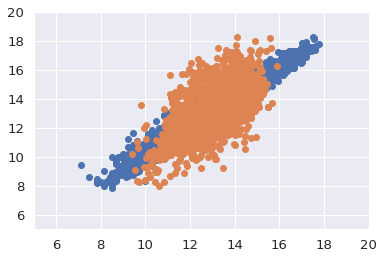

In [304]:
plt.scatter(np.log(medianPrice),np.log(salePrice))
plt.scatter(y_pred,y)
plt.ylim((5,20))
plt.xlim(5,20)

TypeError: ignored

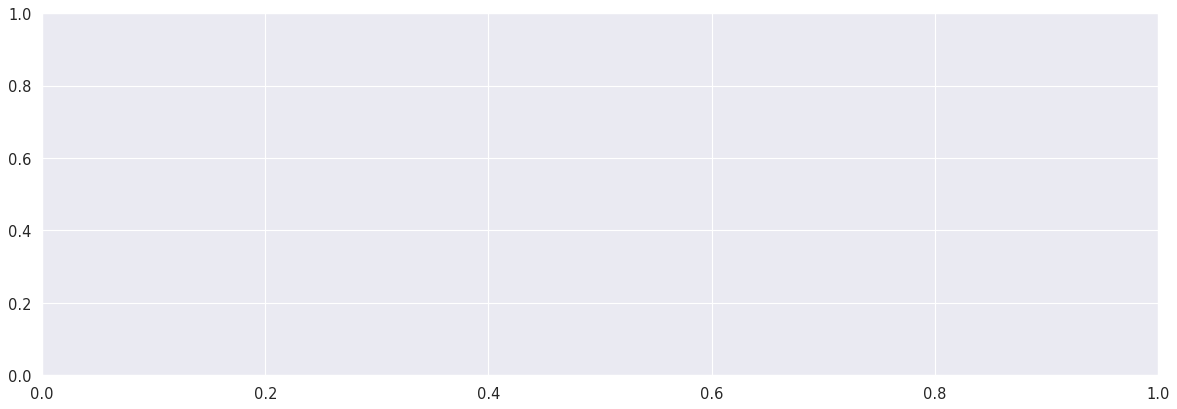

In [255]:
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)
plt.bar(data_proc.iloc[:trainSplit].drop("log_nom_price",axis=1).columns,reg.coef_)
plt.xticks(rotation=90)
print(0)

In [219]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)